In [23]:
from AutoEncoder import myAutoEncoder
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
df = pd.read_csv('/Users/bowen/Desktop/H/deeplearninveststrat/Data/100_clean.csv')
df = df.drop('Unnamed: 0', axis=1)
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
featureList = ['Revenue', 'Cost of Goods Sold', 'SG&A','EBIT', 'Net Income', 
               'Cash and Cash Equivalents', 'Recievables','Inventories', 'Other Current Assets', 
               'PP&E', 'Other Assets', 'Debt in Current Liabilities', 'Accounts Payable', 'Taxes Payable',
               'Other Current Liabilities', 'Total Liabilities']
quarterlyData = {}
dfgb = df.groupby('gvkey')
for gvkey, data in dfgb:
    if len(data) == 115:
        quarterlyData[gvkey] = data.iloc[:114][featureList]

## Denoising with AutoEncoder

In [5]:
def Run(Data):
    n_input = 16
    n_hidden_1 = 11
    n_hidden_2 = 4
    
    AutoEncoder = myAutoEncoder(n_input, n_hidden_1, n_hidden_2)
    X_train, trainDataWithNoise, testData = AutoEncoder.NormalizedStockData(Data)
    
    batch_size = 6
    learning_rate = 0.05
    training_epochs = 150

    X = tf.placeholder("float", [batch_size, n_input])
    y_true = tf.placeholder("float", [batch_size, n_input])
    encoder_op = AutoEncoder.encoder(X)
    decoder_op = AutoEncoder.decoder(encoder_op)
    y_pred = decoder_op
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        for epoch in range(training_epochs):
            row = 0
            for i in range(int(trainDataWithNoise.shape[0] / batch_size)):
                batch_xs = trainDataWithNoise[row:row + batch_size]
                y_xs = X_train[row:row + batch_size]
                row += batch_size
                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, y_true:y_xs })
            print("Epoch:", '%04d' % (epoch + 1), "cost =", "{:.9f}".format(c))
        print("Optimization Finished!")

        result = []
        row = 0
        for i in range(int(testData.shape[0] / batch_size)):
            batch_xs = testData[row:row + batch_size]
            row += batch_size
            res = sess.run(decoder_op, feed_dict={X: batch_xs})
            result.extend(res.tolist())
    return result


def transToDataFrame(result, gvkey, df):
    r = pd.DataFrame(result)
    r.columns = ['Revenue', 'Cost of Goods Sold', 'SG&A','EBIT', 'Net Income', 
               'Cash and Cash Equivalents', 'Recievables','Inventories', 'Other Current Assets', 
               'PP&E', 'Other Assets', 'Debt in Current Liabilities', 'Accounts Payable', 'Taxes Payable',
               'Other Current Liabilities', 'Total Liabilities']
    
    r['timestemp'] = df[df['gvkey'] == gvkey][:-1]['Date'].values
    r['EBIT/EV'] = df[df['gvkey'] == gvkey][:-1]['EBIT/EV'].values
    r['gevkey'] = str(gvkey)
    return r

## test for single stock

In [29]:
data = quarterlyData[1209]

In [31]:
n_input = 16
n_hidden_1 = 11
n_hidden_2 = 4
AutoEncoder = myAutoEncoder(n_input, n_hidden_1, n_hidden_2)
X_train, trainDataWithNoise, testData = AutoEncoder.NormalizedStockData(data)

In [10]:
result = Run(data)

Epoch: 0001 cost = 0.272305042
Epoch: 0002 cost = 0.204936311
Epoch: 0003 cost = 0.184733197
Epoch: 0004 cost = 0.184265241
Epoch: 0005 cost = 0.174867257
Epoch: 0006 cost = 0.158710197
Epoch: 0007 cost = 0.135040894
Epoch: 0008 cost = 0.108944856
Epoch: 0009 cost = 0.087852716
Epoch: 0010 cost = 0.070899174
Epoch: 0011 cost = 0.060787380
Epoch: 0012 cost = 0.053644612
Epoch: 0013 cost = 0.034826767
Epoch: 0014 cost = 0.040307406
Epoch: 0015 cost = 0.053147793
Epoch: 0016 cost = 0.033799674
Epoch: 0017 cost = 0.039009970
Epoch: 0018 cost = 0.034449946
Epoch: 0019 cost = 0.035440553
Epoch: 0020 cost = 0.036877315
Epoch: 0021 cost = 0.034457568
Epoch: 0022 cost = 0.043006089
Epoch: 0023 cost = 0.036133587
Epoch: 0024 cost = 0.035262648
Epoch: 0025 cost = 0.122273542
Epoch: 0026 cost = 0.035823286
Epoch: 0027 cost = 0.053133231
Epoch: 0028 cost = 0.035420269
Epoch: 0029 cost = 0.038425915
Epoch: 0030 cost = 0.036349487
Epoch: 0031 cost = 0.036896620
Epoch: 0032 cost = 0.035665382
Epoch: 0

In [24]:
ha = transToDataFrame(result,1209, df)

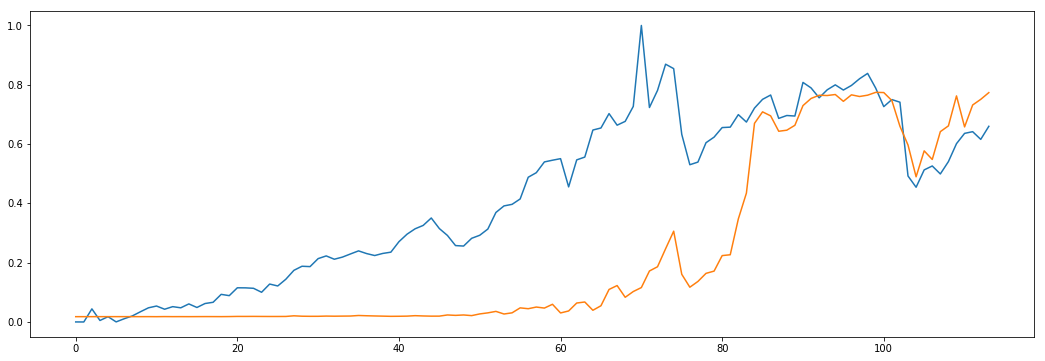

In [33]:
plt.figure(figsize=(18,6))
plt.plot(testData['Revenue'])
plt.plot(ha['Revenue'])

# plt.xlabel('Time')
# plt.ylabel('Rate')
plt.show()

## Denoising all stocks

In [14]:
finalResult = {}
gvkeyList = [i for i in quarterlyData.keys()]
for gvkey in gvkeyList:
    result = Run(quarterlyData[gvkey])
    finalResult[gvkey] = transToDataFrame(result,gvkey, df)

Epoch: 0001 cost = 0.323617905
Epoch: 0002 cost = 0.234526992
Epoch: 0003 cost = 0.197402462
Epoch: 0004 cost = 0.175037682
Epoch: 0005 cost = 0.155463263
Epoch: 0006 cost = 0.135655105
Epoch: 0007 cost = 0.108079612
Epoch: 0008 cost = 0.080102555
Epoch: 0009 cost = 0.059005696
Epoch: 0010 cost = 0.048085991
Epoch: 0011 cost = 0.041462470
Epoch: 0012 cost = 0.035169750
Epoch: 0013 cost = 0.036986355
Epoch: 0014 cost = 0.043455571
Epoch: 0015 cost = 0.035004620
Epoch: 0016 cost = 0.037808217
Epoch: 0017 cost = 0.039526675
Epoch: 0018 cost = 0.032330647
Epoch: 0019 cost = 0.036933661
Epoch: 0020 cost = 0.037872627
Epoch: 0021 cost = 0.047842760
Epoch: 0022 cost = 0.049492065
Epoch: 0023 cost = 0.046948064
Epoch: 0024 cost = 0.038684756
Epoch: 0025 cost = 0.095325761
Epoch: 0026 cost = 0.035030495
Epoch: 0027 cost = 0.042304490
Epoch: 0028 cost = 0.040988341
Epoch: 0029 cost = 0.039173335
Epoch: 0030 cost = 0.038217306
Epoch: 0031 cost = 0.038204599
Epoch: 0032 cost = 0.037507210
Epoch: 0

Epoch: 0120 cost = 0.011679106
Epoch: 0121 cost = 0.012743910
Epoch: 0122 cost = 0.011616942
Epoch: 0123 cost = 0.013150800
Epoch: 0124 cost = 0.011943869
Epoch: 0125 cost = 0.012630455
Epoch: 0126 cost = 0.011903559
Epoch: 0127 cost = 0.012394679
Epoch: 0128 cost = 0.011696129
Epoch: 0129 cost = 0.012227747
Epoch: 0130 cost = 0.011676613
Epoch: 0131 cost = 0.012288715
Epoch: 0132 cost = 0.011708990
Epoch: 0133 cost = 0.012390274
Epoch: 0134 cost = 0.011726973
Epoch: 0135 cost = 0.012688863
Epoch: 0136 cost = 0.011779991
Epoch: 0137 cost = 0.013256487
Epoch: 0138 cost = 0.011512953
Epoch: 0139 cost = 0.012520685
Epoch: 0140 cost = 0.011713889
Epoch: 0141 cost = 0.012490782
Epoch: 0142 cost = 0.011974707
Epoch: 0143 cost = 0.012425852
Epoch: 0144 cost = 0.012344033
Epoch: 0145 cost = 0.012441055
Epoch: 0146 cost = 0.014069900
Epoch: 0147 cost = 0.013887469
Epoch: 0148 cost = 0.013076416
Epoch: 0149 cost = 0.011794488
Epoch: 0150 cost = 0.011604198
Optimization Finished!
Epoch: 0001 cost

Epoch: 0103 cost = 0.007037129
Epoch: 0104 cost = 0.008387051
Epoch: 0105 cost = 0.008460685
Epoch: 0106 cost = 0.008588814
Epoch: 0107 cost = 0.008482787
Epoch: 0108 cost = 0.008216466
Epoch: 0109 cost = 0.007945965
Epoch: 0110 cost = 0.007655922
Epoch: 0111 cost = 0.007549835
Epoch: 0112 cost = 0.007320283
Epoch: 0113 cost = 0.007351903
Epoch: 0114 cost = 0.007149993
Epoch: 0115 cost = 0.007286360
Epoch: 0116 cost = 0.007484661
Epoch: 0117 cost = 0.007715814
Epoch: 0118 cost = 0.007879814
Epoch: 0119 cost = 0.034344036
Epoch: 0120 cost = 0.006700512
Epoch: 0121 cost = 0.019051388
Epoch: 0122 cost = 0.006484393
Epoch: 0123 cost = 0.006965688
Epoch: 0124 cost = 0.007842381
Epoch: 0125 cost = 0.006985831
Epoch: 0126 cost = 0.007357836
Epoch: 0127 cost = 0.006930260
Epoch: 0128 cost = 0.007482493
Epoch: 0129 cost = 0.007067692
Epoch: 0130 cost = 0.010005831
Epoch: 0131 cost = 0.007545003
Epoch: 0132 cost = 0.010924106
Epoch: 0133 cost = 0.007754685
Epoch: 0134 cost = 0.007742118
Epoch: 0

Epoch: 0067 cost = 0.028966969
Epoch: 0068 cost = 0.027038159
Epoch: 0069 cost = 0.026936861
Epoch: 0070 cost = 0.025113940
Epoch: 0071 cost = 0.025508611
Epoch: 0072 cost = 0.023558527
Epoch: 0073 cost = 0.024438107
Epoch: 0074 cost = 0.022565760
Epoch: 0075 cost = 0.023198932
Epoch: 0076 cost = 0.021912068
Epoch: 0077 cost = 0.021691119
Epoch: 0078 cost = 0.022188514
Epoch: 0079 cost = 0.020546185
Epoch: 0080 cost = 0.022734025
Epoch: 0081 cost = 0.019431874
Epoch: 0082 cost = 0.020810507
Epoch: 0083 cost = 0.020152882
Epoch: 0084 cost = 0.019358804
Epoch: 0085 cost = 0.021511296
Epoch: 0086 cost = 0.017767478
Epoch: 0087 cost = 0.021357194
Epoch: 0088 cost = 0.017955855
Epoch: 0089 cost = 0.019924689
Epoch: 0090 cost = 0.017761590
Epoch: 0091 cost = 0.019018346
Epoch: 0092 cost = 0.017530024
Epoch: 0093 cost = 0.017300108
Epoch: 0094 cost = 0.020644406
Epoch: 0095 cost = 0.016473318
Epoch: 0096 cost = 0.020692199
Epoch: 0097 cost = 0.019141508
Epoch: 0098 cost = 0.016388424
Epoch: 0

Epoch: 0042 cost = 0.009697891
Epoch: 0043 cost = 0.013775057
Epoch: 0044 cost = 0.007057483
Epoch: 0045 cost = 0.011321475
Epoch: 0046 cost = 0.008714396
Epoch: 0047 cost = 0.008070429
Epoch: 0048 cost = 0.009318077
Epoch: 0049 cost = 0.007689921
Epoch: 0050 cost = 0.008312425
Epoch: 0051 cost = 0.009437772
Epoch: 0052 cost = 0.006681157
Epoch: 0053 cost = 0.009866524
Epoch: 0054 cost = 0.006351979
Epoch: 0055 cost = 0.008776583
Epoch: 0056 cost = 0.008125939
Epoch: 0057 cost = 0.008044396
Epoch: 0058 cost = 0.007065120
Epoch: 0059 cost = 0.009975979
Epoch: 0060 cost = 0.005421137
Epoch: 0061 cost = 0.008637314
Epoch: 0062 cost = 0.007059805
Epoch: 0063 cost = 0.006092236
Epoch: 0064 cost = 0.008725702
Epoch: 0065 cost = 0.007550752
Epoch: 0066 cost = 0.005810694
Epoch: 0067 cost = 0.009011618
Epoch: 0068 cost = 0.005106032
Epoch: 0069 cost = 0.006681935
Epoch: 0070 cost = 0.007686567
Epoch: 0071 cost = 0.005505911
Epoch: 0072 cost = 0.007554298
Epoch: 0073 cost = 0.008727834
Epoch: 0

Epoch: 0025 cost = 0.042989265
Epoch: 0026 cost = 0.053949684
Epoch: 0027 cost = 0.047839329
Epoch: 0028 cost = 0.048216123
Epoch: 0029 cost = 0.043991949
Epoch: 0030 cost = 0.042837709
Epoch: 0031 cost = 0.042899955
Epoch: 0032 cost = 0.041702494
Epoch: 0033 cost = 0.040881488
Epoch: 0034 cost = 0.039919347
Epoch: 0035 cost = 0.043108802
Epoch: 0036 cost = 0.039071158
Epoch: 0037 cost = 0.071060039
Epoch: 0038 cost = 0.036125470
Epoch: 0039 cost = 0.047376454
Epoch: 0040 cost = 0.048926592
Epoch: 0041 cost = 0.047191396
Epoch: 0042 cost = 0.044602364
Epoch: 0043 cost = 0.042150963
Epoch: 0044 cost = 0.041207369
Epoch: 0045 cost = 0.039933261
Epoch: 0046 cost = 0.038848661
Epoch: 0047 cost = 0.038210765
Epoch: 0048 cost = 0.037532657
Epoch: 0049 cost = 0.036996335
Epoch: 0050 cost = 0.036438253
Epoch: 0051 cost = 0.035981108
Epoch: 0052 cost = 0.035354286
Epoch: 0053 cost = 0.034920339
Epoch: 0054 cost = 0.034245189
Epoch: 0055 cost = 0.034068014
Epoch: 0056 cost = 0.033219289
Epoch: 0

Epoch: 0141 cost = 0.021046117
Epoch: 0142 cost = 0.021687901
Epoch: 0143 cost = 0.020972943
Epoch: 0144 cost = 0.022181680
Epoch: 0145 cost = 0.021062262
Epoch: 0146 cost = 0.022479845
Epoch: 0147 cost = 0.021090545
Epoch: 0148 cost = 0.022406371
Epoch: 0149 cost = 0.021023681
Epoch: 0150 cost = 0.022061944
Optimization Finished!
Epoch: 0001 cost = 0.248882771
Epoch: 0002 cost = 0.226108491
Epoch: 0003 cost = 0.194328442
Epoch: 0004 cost = 0.187577143
Epoch: 0005 cost = 0.181858286
Epoch: 0006 cost = 0.173102781
Epoch: 0007 cost = 0.166813448
Epoch: 0008 cost = 0.152465060
Epoch: 0009 cost = 0.132503927
Epoch: 0010 cost = 0.113102518
Epoch: 0011 cost = 0.088697106
Epoch: 0012 cost = 0.080816895
Epoch: 0013 cost = 0.090220995
Epoch: 0014 cost = 0.079614714
Epoch: 0015 cost = 0.063986875
Epoch: 0016 cost = 0.087759934
Epoch: 0017 cost = 0.082115442
Epoch: 0018 cost = 0.064104646
Epoch: 0019 cost = 0.082446910
Epoch: 0020 cost = 0.065969869
Epoch: 0021 cost = 0.064341962
Epoch: 0022 cost

Epoch: 0116 cost = 0.033443470
Epoch: 0117 cost = 0.035379447
Epoch: 0118 cost = 0.035165478
Epoch: 0119 cost = 0.035705678
Epoch: 0120 cost = 0.035207827
Epoch: 0121 cost = 0.034779493
Epoch: 0122 cost = 0.034106437
Epoch: 0123 cost = 0.033776566
Epoch: 0124 cost = 0.034415159
Epoch: 0125 cost = 0.043671589
Epoch: 0126 cost = 0.033111829
Epoch: 0127 cost = 0.037062775
Epoch: 0128 cost = 0.032942403
Epoch: 0129 cost = 0.034058776
Epoch: 0130 cost = 0.032132495
Epoch: 0131 cost = 0.035105389
Epoch: 0132 cost = 0.033196013
Epoch: 0133 cost = 0.034418605
Epoch: 0134 cost = 0.032929059
Epoch: 0135 cost = 0.036807168
Epoch: 0136 cost = 0.033071619
Epoch: 0137 cost = 0.042296361
Epoch: 0138 cost = 0.032188594
Epoch: 0139 cost = 0.034555513
Epoch: 0140 cost = 0.034999616
Epoch: 0141 cost = 0.035507482
Epoch: 0142 cost = 0.036286291
Epoch: 0143 cost = 0.036197562
Epoch: 0144 cost = 0.036318511
Epoch: 0145 cost = 0.035634819
Epoch: 0146 cost = 0.035555307
Epoch: 0147 cost = 0.035385951
Epoch: 0

Epoch: 0093 cost = 0.015592419
Epoch: 0094 cost = 0.014975936
Epoch: 0095 cost = 0.015116203
Epoch: 0096 cost = 0.014966761
Epoch: 0097 cost = 0.015488011
Epoch: 0098 cost = 0.015963372
Epoch: 0099 cost = 0.018876886
Epoch: 0100 cost = 0.025338531
Epoch: 0101 cost = 0.015012910
Epoch: 0102 cost = 0.045517262
Epoch: 0103 cost = 0.022413978
Epoch: 0104 cost = 0.021839289
Epoch: 0105 cost = 0.021597723
Epoch: 0106 cost = 0.017641960
Epoch: 0107 cost = 0.015605281
Epoch: 0108 cost = 0.016177870
Epoch: 0109 cost = 0.015661253
Epoch: 0110 cost = 0.014708289
Epoch: 0111 cost = 0.014983307
Epoch: 0112 cost = 0.015349717
Epoch: 0113 cost = 0.016859861
Epoch: 0114 cost = 0.016439663
Epoch: 0115 cost = 0.014993570
Epoch: 0116 cost = 0.017077453
Epoch: 0117 cost = 0.015472256
Epoch: 0118 cost = 0.015339844
Epoch: 0119 cost = 0.014116160
Epoch: 0120 cost = 0.013758372
Epoch: 0121 cost = 0.013101240
Epoch: 0122 cost = 0.013197749
Epoch: 0123 cost = 0.012598936
Epoch: 0124 cost = 0.012342009
Epoch: 0

Epoch: 0071 cost = 0.012855466
Epoch: 0072 cost = 0.019106228
Epoch: 0073 cost = 0.011757036
Epoch: 0074 cost = 0.016735613
Epoch: 0075 cost = 0.012841803
Epoch: 0076 cost = 0.016096210
Epoch: 0077 cost = 0.011661582
Epoch: 0078 cost = 0.013505448
Epoch: 0079 cost = 0.010959141
Epoch: 0080 cost = 0.011615421
Epoch: 0081 cost = 0.010675621
Epoch: 0082 cost = 0.010129128
Epoch: 0083 cost = 0.010838824
Epoch: 0084 cost = 0.010844422
Epoch: 0085 cost = 0.021087205
Epoch: 0086 cost = 0.013475440
Epoch: 0087 cost = 0.014351857
Epoch: 0088 cost = 0.011211716
Epoch: 0089 cost = 0.010098558
Epoch: 0090 cost = 0.011021282
Epoch: 0091 cost = 0.009862681
Epoch: 0092 cost = 0.011539171
Epoch: 0093 cost = 0.009634594
Epoch: 0094 cost = 0.012080352
Epoch: 0095 cost = 0.009210683
Epoch: 0096 cost = 0.011075852
Epoch: 0097 cost = 0.008836080
Epoch: 0098 cost = 0.010551267
Epoch: 0099 cost = 0.008394630
Epoch: 0100 cost = 0.010359355
Epoch: 0101 cost = 0.008174462
Epoch: 0102 cost = 0.010634783
Epoch: 0

Epoch: 0048 cost = 0.025507083
Epoch: 0049 cost = 0.023563266
Epoch: 0050 cost = 0.023106329
Epoch: 0051 cost = 0.023075501
Epoch: 0052 cost = 0.022667252
Epoch: 0053 cost = 0.021603128
Epoch: 0054 cost = 0.041212399
Epoch: 0055 cost = 0.020182667
Epoch: 0056 cost = 0.036599834
Epoch: 0057 cost = 0.025538141
Epoch: 0058 cost = 0.025168872
Epoch: 0059 cost = 0.023330001
Epoch: 0060 cost = 0.023647187
Epoch: 0061 cost = 0.023699328
Epoch: 0062 cost = 0.023984870
Epoch: 0063 cost = 0.023918474
Epoch: 0064 cost = 0.023385130
Epoch: 0065 cost = 0.022219062
Epoch: 0066 cost = 0.022596734
Epoch: 0067 cost = 0.021652436
Epoch: 0068 cost = 0.022288008
Epoch: 0069 cost = 0.021894991
Epoch: 0070 cost = 0.022551009
Epoch: 0071 cost = 0.020033054
Epoch: 0072 cost = 0.029135039
Epoch: 0073 cost = 0.023074863
Epoch: 0074 cost = 0.023696350
Epoch: 0075 cost = 0.023547983
Epoch: 0076 cost = 0.022226939
Epoch: 0077 cost = 0.021922888
Epoch: 0078 cost = 0.022916177
Epoch: 0079 cost = 0.021985700
Epoch: 0

Epoch: 0025 cost = 0.021388153
Epoch: 0026 cost = 0.027251100
Epoch: 0027 cost = 0.021086209
Epoch: 0028 cost = 0.019541083
Epoch: 0029 cost = 0.024546346
Epoch: 0030 cost = 0.027442351
Epoch: 0031 cost = 0.024152773
Epoch: 0032 cost = 0.021790439
Epoch: 0033 cost = 0.018854333
Epoch: 0034 cost = 0.018374352
Epoch: 0035 cost = 0.017854415
Epoch: 0036 cost = 0.018126853
Epoch: 0037 cost = 0.016647348
Epoch: 0038 cost = 0.015952913
Epoch: 0039 cost = 0.014319646
Epoch: 0040 cost = 0.015521617
Epoch: 0041 cost = 0.013938419
Epoch: 0042 cost = 0.015270032
Epoch: 0043 cost = 0.017254386
Epoch: 0044 cost = 0.017721115
Epoch: 0045 cost = 0.027073195
Epoch: 0046 cost = 0.016665613
Epoch: 0047 cost = 0.015393722
Epoch: 0048 cost = 0.020771636
Epoch: 0049 cost = 0.013604142
Epoch: 0050 cost = 0.014377914
Epoch: 0051 cost = 0.014533199
Epoch: 0052 cost = 0.013958596
Epoch: 0053 cost = 0.013000864
Epoch: 0054 cost = 0.014939741
Epoch: 0055 cost = 0.013969232
Epoch: 0056 cost = 0.013499059
Epoch: 0

Epoch: 0001 cost = 0.163506329
Epoch: 0002 cost = 0.117620982
Epoch: 0003 cost = 0.113123931
Epoch: 0004 cost = 0.116872609
Epoch: 0005 cost = 0.114996307
Epoch: 0006 cost = 0.111570865
Epoch: 0007 cost = 0.111119598
Epoch: 0008 cost = 0.108738713
Epoch: 0009 cost = 0.105232418
Epoch: 0010 cost = 0.100683302
Epoch: 0011 cost = 0.094386481
Epoch: 0012 cost = 0.084807120
Epoch: 0013 cost = 0.072214186
Epoch: 0014 cost = 0.072171718
Epoch: 0015 cost = 0.069434479
Epoch: 0016 cost = 0.048573893
Epoch: 0017 cost = 0.054806456
Epoch: 0018 cost = 0.056565989
Epoch: 0019 cost = 0.048666656
Epoch: 0020 cost = 0.044193536
Epoch: 0021 cost = 0.039801080
Epoch: 0022 cost = 0.032335248
Epoch: 0023 cost = 0.038388681
Epoch: 0024 cost = 0.032703564
Epoch: 0025 cost = 0.030830219
Epoch: 0026 cost = 0.034762930
Epoch: 0027 cost = 0.029038588
Epoch: 0028 cost = 0.027528292
Epoch: 0029 cost = 0.029259721
Epoch: 0030 cost = 0.026825519
Epoch: 0031 cost = 0.028743530
Epoch: 0032 cost = 0.029880688
Epoch: 0

Epoch: 0115 cost = 0.036670450
Epoch: 0116 cost = 0.040091317
Epoch: 0117 cost = 0.036528703
Epoch: 0118 cost = 0.038113851
Epoch: 0119 cost = 0.036290720
Epoch: 0120 cost = 0.037392095
Epoch: 0121 cost = 0.036281232
Epoch: 0122 cost = 0.037799098
Epoch: 0123 cost = 0.036578760
Epoch: 0124 cost = 0.039763056
Epoch: 0125 cost = 0.036841415
Epoch: 0126 cost = 0.037693340
Epoch: 0127 cost = 0.035176620
Epoch: 0128 cost = 0.037358094
Epoch: 0129 cost = 0.034992188
Epoch: 0130 cost = 0.037629765
Epoch: 0131 cost = 0.035408456
Epoch: 0132 cost = 0.037653606
Epoch: 0133 cost = 0.034812037
Epoch: 0134 cost = 0.033803944
Epoch: 0135 cost = 0.033687040
Epoch: 0136 cost = 0.038457941
Epoch: 0137 cost = 0.034233261
Epoch: 0138 cost = 0.039651629
Epoch: 0139 cost = 0.034326926
Epoch: 0140 cost = 0.033345051
Epoch: 0141 cost = 0.031927675
Epoch: 0142 cost = 0.031196564
Epoch: 0143 cost = 0.030617267
Epoch: 0144 cost = 0.030621894
Epoch: 0145 cost = 0.030889204
Epoch: 0146 cost = 0.038226355
Epoch: 0

Epoch: 0094 cost = 0.002227137
Epoch: 0095 cost = 0.000999127
Epoch: 0096 cost = 0.002443671
Epoch: 0097 cost = 0.001172908
Epoch: 0098 cost = 0.001261326
Epoch: 0099 cost = 0.002281321
Epoch: 0100 cost = 0.001201031
Epoch: 0101 cost = 0.002511028
Epoch: 0102 cost = 0.002260266
Epoch: 0103 cost = 0.013330345
Epoch: 0104 cost = 0.000968915
Epoch: 0105 cost = 0.099387348
Epoch: 0106 cost = 0.001598066
Epoch: 0107 cost = 0.003119047
Epoch: 0108 cost = 0.004410624
Epoch: 0109 cost = 0.002631095
Epoch: 0110 cost = 0.001827683
Epoch: 0111 cost = 0.001315469
Epoch: 0112 cost = 0.001443879
Epoch: 0113 cost = 0.001383228
Epoch: 0114 cost = 0.001657442
Epoch: 0115 cost = 0.001316027
Epoch: 0116 cost = 0.001888670
Epoch: 0117 cost = 0.001436076
Epoch: 0118 cost = 0.002076649
Epoch: 0119 cost = 0.001566613
Epoch: 0120 cost = 0.002068547
Epoch: 0121 cost = 0.001625554
Epoch: 0122 cost = 0.001752056
Epoch: 0123 cost = 0.001675971
Epoch: 0124 cost = 0.001481635
Epoch: 0125 cost = 0.001648529
Epoch: 0

Epoch: 0071 cost = 0.027952591
Epoch: 0072 cost = 0.027565882
Epoch: 0073 cost = 0.026437417
Epoch: 0074 cost = 0.026622877
Epoch: 0075 cost = 0.027319767
Epoch: 0076 cost = 0.026301989
Epoch: 0077 cost = 0.026111498
Epoch: 0078 cost = 0.025560269
Epoch: 0079 cost = 0.024800867
Epoch: 0080 cost = 0.025117850
Epoch: 0081 cost = 0.024570638
Epoch: 0082 cost = 0.024246091
Epoch: 0083 cost = 0.027163783
Epoch: 0084 cost = 0.030520318
Epoch: 0085 cost = 0.025459299
Epoch: 0086 cost = 0.028362103
Epoch: 0087 cost = 0.025416054
Epoch: 0088 cost = 0.025217913
Epoch: 0089 cost = 0.024694210
Epoch: 0090 cost = 0.024798954
Epoch: 0091 cost = 0.023216477
Epoch: 0092 cost = 0.023106715
Epoch: 0093 cost = 0.022136966
Epoch: 0094 cost = 0.022394983
Epoch: 0095 cost = 0.022247197
Epoch: 0096 cost = 0.022313876
Epoch: 0097 cost = 0.022383178
Epoch: 0098 cost = 0.022591956
Epoch: 0099 cost = 0.022163237
Epoch: 0100 cost = 0.022826761
Epoch: 0101 cost = 0.021438977
Epoch: 0102 cost = 0.021462696
Epoch: 0

Epoch: 0049 cost = 0.018114204
Epoch: 0050 cost = 0.014772497
Epoch: 0051 cost = 0.017974662
Epoch: 0052 cost = 0.013415661
Epoch: 0053 cost = 0.017495658
Epoch: 0054 cost = 0.013381015
Epoch: 0055 cost = 0.016652476
Epoch: 0056 cost = 0.012471220
Epoch: 0057 cost = 0.015124477
Epoch: 0058 cost = 0.011722501
Epoch: 0059 cost = 0.013405520
Epoch: 0060 cost = 0.011260447
Epoch: 0061 cost = 0.012372859
Epoch: 0062 cost = 0.010703233
Epoch: 0063 cost = 0.012345592
Epoch: 0064 cost = 0.010343469
Epoch: 0065 cost = 0.012544016
Epoch: 0066 cost = 0.010176238
Epoch: 0067 cost = 0.012557417
Epoch: 0068 cost = 0.010078309
Epoch: 0069 cost = 0.012249933
Epoch: 0070 cost = 0.009881516
Epoch: 0071 cost = 0.011764652
Epoch: 0072 cost = 0.009693679
Epoch: 0073 cost = 0.011074618
Epoch: 0074 cost = 0.009480699
Epoch: 0075 cost = 0.010956989
Epoch: 0076 cost = 0.009345857
Epoch: 0077 cost = 0.011413596
Epoch: 0078 cost = 0.009339281
Epoch: 0079 cost = 0.011604856
Epoch: 0080 cost = 0.009344717
Epoch: 0

Epoch: 0025 cost = 0.066077940
Epoch: 0026 cost = 0.043911297
Epoch: 0027 cost = 0.055584162
Epoch: 0028 cost = 0.043442428
Epoch: 0029 cost = 0.037946355
Epoch: 0030 cost = 0.068564944
Epoch: 0031 cost = 0.054575771
Epoch: 0032 cost = 0.041643087
Epoch: 0033 cost = 0.035586271
Epoch: 0034 cost = 0.028012356
Epoch: 0035 cost = 0.068157025
Epoch: 0036 cost = 0.034382433
Epoch: 0037 cost = 0.046083007
Epoch: 0038 cost = 0.044679020
Epoch: 0039 cost = 0.035751168
Epoch: 0040 cost = 0.044934239
Epoch: 0041 cost = 0.028905401
Epoch: 0042 cost = 0.041915026
Epoch: 0043 cost = 0.028621597
Epoch: 0044 cost = 0.034178581
Epoch: 0045 cost = 0.027871596
Epoch: 0046 cost = 0.028921174
Epoch: 0047 cost = 0.026447700
Epoch: 0048 cost = 0.025870278
Epoch: 0049 cost = 0.023963073
Epoch: 0050 cost = 0.023683513
Epoch: 0051 cost = 0.022396214
Epoch: 0052 cost = 0.027535295
Epoch: 0053 cost = 0.021322479
Epoch: 0054 cost = 0.053173184
Epoch: 0055 cost = 0.021007961
Epoch: 0056 cost = 0.027222296
Epoch: 0

Epoch: 0141 cost = 0.005056967
Epoch: 0142 cost = 0.004990611
Epoch: 0143 cost = 0.004823412
Epoch: 0144 cost = 0.004504584
Epoch: 0145 cost = 0.004338553
Epoch: 0146 cost = 0.004591253
Epoch: 0147 cost = 0.005016762
Epoch: 0148 cost = 0.005108902
Epoch: 0149 cost = 0.004374817
Epoch: 0150 cost = 0.005556285
Optimization Finished!
Epoch: 0001 cost = 0.304769546
Epoch: 0002 cost = 0.148300990
Epoch: 0003 cost = 0.164081410
Epoch: 0004 cost = 0.172076657
Epoch: 0005 cost = 0.140667260
Epoch: 0006 cost = 0.115731932
Epoch: 0007 cost = 0.095908962
Epoch: 0008 cost = 0.082848333
Epoch: 0009 cost = 0.083072156
Epoch: 0010 cost = 0.071272343
Epoch: 0011 cost = 0.080916531
Epoch: 0012 cost = 0.076216541
Epoch: 0013 cost = 0.075094603
Epoch: 0014 cost = 0.071623035
Epoch: 0015 cost = 0.062846161
Epoch: 0016 cost = 0.060405076
Epoch: 0017 cost = 0.063620210
Epoch: 0018 cost = 0.057325829
Epoch: 0019 cost = 0.052451044
Epoch: 0020 cost = 0.052803632
Epoch: 0021 cost = 0.067992710
Epoch: 0022 cost

Epoch: 0118 cost = 0.009057740
Epoch: 0119 cost = 0.012436508
Epoch: 0120 cost = 0.008293851
Epoch: 0121 cost = 0.008836248
Epoch: 0122 cost = 0.007704526
Epoch: 0123 cost = 0.007846739
Epoch: 0124 cost = 0.007353710
Epoch: 0125 cost = 0.007483569
Epoch: 0126 cost = 0.007419028
Epoch: 0127 cost = 0.007442437
Epoch: 0128 cost = 0.007258456
Epoch: 0129 cost = 0.007248083
Epoch: 0130 cost = 0.007513749
Epoch: 0131 cost = 0.008911495
Epoch: 0132 cost = 0.007839733
Epoch: 0133 cost = 0.008981836
Epoch: 0134 cost = 0.008335435
Epoch: 0135 cost = 0.010205245
Epoch: 0136 cost = 0.007242908
Epoch: 0137 cost = 0.008409900
Epoch: 0138 cost = 0.007333613
Epoch: 0139 cost = 0.007520378
Epoch: 0140 cost = 0.006764414
Epoch: 0141 cost = 0.007917937
Epoch: 0142 cost = 0.006462025
Epoch: 0143 cost = 0.007008296
Epoch: 0144 cost = 0.006680932
Epoch: 0145 cost = 0.006711606
Epoch: 0146 cost = 0.006450656
Epoch: 0147 cost = 0.006398945
Epoch: 0148 cost = 0.006451197
Epoch: 0149 cost = 0.006397041
Epoch: 0

Epoch: 0098 cost = 0.013718500
Epoch: 0099 cost = 0.012509153
Epoch: 0100 cost = 0.013981611
Epoch: 0101 cost = 0.012206907
Epoch: 0102 cost = 0.014356702
Epoch: 0103 cost = 0.012027711
Epoch: 0104 cost = 0.014095847
Epoch: 0105 cost = 0.012216034
Epoch: 0106 cost = 0.012702701
Epoch: 0107 cost = 0.012324587
Epoch: 0108 cost = 0.013124692
Epoch: 0109 cost = 0.012396728
Epoch: 0110 cost = 0.012968659
Epoch: 0111 cost = 0.012448994
Epoch: 0112 cost = 0.012968752
Epoch: 0113 cost = 0.012366824
Epoch: 0114 cost = 0.013178427
Epoch: 0115 cost = 0.012494181
Epoch: 0116 cost = 0.013730059
Epoch: 0117 cost = 0.013399400
Epoch: 0118 cost = 0.013522723
Epoch: 0119 cost = 0.014059099
Epoch: 0120 cost = 0.013044287
Epoch: 0121 cost = 0.013754354
Epoch: 0122 cost = 0.012075871
Epoch: 0123 cost = 0.014092677
Epoch: 0124 cost = 0.012045923
Epoch: 0125 cost = 0.013238042
Epoch: 0126 cost = 0.012228587
Epoch: 0127 cost = 0.012228042
Epoch: 0128 cost = 0.012443658
Epoch: 0129 cost = 0.012533451
Epoch: 0

Epoch: 0079 cost = 0.014254221
Epoch: 0080 cost = 0.014194581
Epoch: 0081 cost = 0.013858638
Epoch: 0082 cost = 0.013540373
Epoch: 0083 cost = 0.013719392
Epoch: 0084 cost = 0.013816149
Epoch: 0085 cost = 0.013898410
Epoch: 0086 cost = 0.014664103
Epoch: 0087 cost = 0.014823664
Epoch: 0088 cost = 0.014604646
Epoch: 0089 cost = 0.015290885
Epoch: 0090 cost = 0.016840899
Epoch: 0091 cost = 0.014730182
Epoch: 0092 cost = 0.013414645
Epoch: 0093 cost = 0.014323760
Epoch: 0094 cost = 0.012326743
Epoch: 0095 cost = 0.012737665
Epoch: 0096 cost = 0.012992017
Epoch: 0097 cost = 0.012482460
Epoch: 0098 cost = 0.011591851
Epoch: 0099 cost = 0.013978516
Epoch: 0100 cost = 0.012972292
Epoch: 0101 cost = 0.013056689
Epoch: 0102 cost = 0.013033181
Epoch: 0103 cost = 0.011396013
Epoch: 0104 cost = 0.011951822
Epoch: 0105 cost = 0.013596900
Epoch: 0106 cost = 0.011586584
Epoch: 0107 cost = 0.011602148
Epoch: 0108 cost = 0.011403475
Epoch: 0109 cost = 0.010185714
Epoch: 0110 cost = 0.011768617
Epoch: 0

Epoch: 0046 cost = 0.033508603
Epoch: 0047 cost = 0.029672349
Epoch: 0048 cost = 0.041152392
Epoch: 0049 cost = 0.030009245
Epoch: 0050 cost = 0.034188103
Epoch: 0051 cost = 0.029096762
Epoch: 0052 cost = 0.029987797
Epoch: 0053 cost = 0.028087646
Epoch: 0054 cost = 0.028178474
Epoch: 0055 cost = 0.027110094
Epoch: 0056 cost = 0.029751843
Epoch: 0057 cost = 0.028409891
Epoch: 0058 cost = 0.042915687
Epoch: 0059 cost = 0.030972064
Epoch: 0060 cost = 0.037068505
Epoch: 0061 cost = 0.028937660
Epoch: 0062 cost = 0.028889343
Epoch: 0063 cost = 0.027886210
Epoch: 0064 cost = 0.027336599
Epoch: 0065 cost = 0.026351241
Epoch: 0066 cost = 0.027110064
Epoch: 0067 cost = 0.026134433
Epoch: 0068 cost = 0.036373965
Epoch: 0069 cost = 0.029786944
Epoch: 0070 cost = 0.041728377
Epoch: 0071 cost = 0.028465644
Epoch: 0072 cost = 0.029245367
Epoch: 0073 cost = 0.026943117
Epoch: 0074 cost = 0.027129412
Epoch: 0075 cost = 0.026002802
Epoch: 0076 cost = 0.025330162
Epoch: 0077 cost = 0.024843404
Epoch: 0

Epoch: 0022 cost = 0.032396890
Epoch: 0023 cost = 0.033740085
Epoch: 0024 cost = 0.036735419
Epoch: 0025 cost = 0.033177596
Epoch: 0026 cost = 0.035962489
Epoch: 0027 cost = 0.031877887
Epoch: 0028 cost = 0.030864825
Epoch: 0029 cost = 0.030954173
Epoch: 0030 cost = 0.029555762
Epoch: 0031 cost = 0.029269909
Epoch: 0032 cost = 0.028799767
Epoch: 0033 cost = 0.027879933
Epoch: 0034 cost = 0.028203050
Epoch: 0035 cost = 0.026810111
Epoch: 0036 cost = 0.027678952
Epoch: 0037 cost = 0.026133856
Epoch: 0038 cost = 0.027190091
Epoch: 0039 cost = 0.025688857
Epoch: 0040 cost = 0.026732132
Epoch: 0041 cost = 0.025304353
Epoch: 0042 cost = 0.026404744
Epoch: 0043 cost = 0.025000453
Epoch: 0044 cost = 0.026006980
Epoch: 0045 cost = 0.024813905
Epoch: 0046 cost = 0.025895497
Epoch: 0047 cost = 0.024715627
Epoch: 0048 cost = 0.025771340
Epoch: 0049 cost = 0.024848802
Epoch: 0050 cost = 0.025694484
Epoch: 0051 cost = 0.024874499
Epoch: 0052 cost = 0.025947953
Epoch: 0053 cost = 0.025064511
Epoch: 0

Epoch: 0139 cost = 0.068980537
Epoch: 0140 cost = 0.045214076
Epoch: 0141 cost = 0.038243018
Epoch: 0142 cost = 0.037850697
Epoch: 0143 cost = 0.035766631
Epoch: 0144 cost = 0.034930170
Epoch: 0145 cost = 0.034899443
Epoch: 0146 cost = 0.035635352
Epoch: 0147 cost = 0.042813748
Epoch: 0148 cost = 0.063622884
Epoch: 0149 cost = 0.066311061
Epoch: 0150 cost = 0.050535250
Optimization Finished!


In [15]:
finalResult = pd.concat([v.assign(gvkey=k) for k, v in finalResult.items()], ignore_index=True)

In [17]:
finalResult.to_csv('DenoisngData.csv')